In [45]:
from fastapi import FastAPI, HTTPException
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel
import dotenv
import pendulum
from sqlalchemy import create_engine, desc
from sqlalchemy.orm import sessionmaker
from config import Settings
from models import MessageSql
import matplotlib.pyplot as plt
import pandas as pd

settings = Settings(_env_file=dotenv.find_dotenv())
valid_password = settings.thermostat_api_key.get_secret_value()
engine = create_engine(settings.db_url.get_secret_value())
Session = sessionmaker(bind=engine)


session = Session()
timezone = "America/New_York"
start = pendulum.datetime(2024, 10, 14, 10, 0, tz=timezone)
end = pendulum.datetime(2024, 10, 14, 23, 0, tz=timezone)
start_ms = int(start.timestamp() * 1000)
end_ms = int(end.timestamp() * 1000)

messages = session.query(MessageSql).filter(
    MessageSql.from_alias.like(f'%fir%'),
    MessageSql.message_persisted_ms >= start_ms,
    MessageSql.message_persisted_ms <= end_ms,
).order_by(desc(MessageSql.message_persisted_ms)).all()

In [46]:
hp_odu_pwr = []
hp_odu_pwr_times = []
hp_idu_pwr = []
hp_idu_pwr_times = []
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if 'hp-odu-pwr' in channel['ChannelName']:
            hp_odu_pwr.extend(channel['ValueList'])            
            hp_odu_pwr_times.extend(channel['ScadaReadTimeUnixMsList'])            
        elif 'hp-idu-pwr' in channel['ChannelName']:
            hp_idu_pwr.extend(channel['ValueList'])
            hp_idu_pwr_times.extend(channel['ScadaReadTimeUnixMsList'])

hp_power_data = {
    'hp_odu_pwr': hp_odu_pwr,
    'hp_idu_pwr': hp_idu_pwr,
}

In [47]:
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if channel['ChannelName'] not in channels:
            channels[channel['ChannelName']] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel['ChannelName']]['values'].extend(channel['ValueList'])
            channels[channel['ChannelName']]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
first_time = 1e9**2
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['times'] = list(sorted_times)
    channels[key]['values'] = list(sorted_values)
    if channels[key]['times'][0] < first_time:
        first_time = channels[key]['times'][0]

In [48]:
# First plot: HP loop
for key in channels.keys():
    print(key)

hp-odu-pwr
hp-idu-pwr
dist-pump-pwr
primary-pump-pwr
store-pump-pwr
zone1-whitewire-pwr
zone2-whitewire-pwr
zone3-whitewire-pwr
zone4-whitewire-pwr
zone1-mainfloor-temp
zone1-mainfloor-set
zone1-mainfloor-state
zone2-masterbed-temp
zone2-masterbed-set
zone2-masterbed-state
zone3-upstairsbed-temp
zone3-upstairsbed-set
zone3-upstairsbed-state
zone4-sunroom-temp
zone4-sunroom-set
zone4-sunroom-state
dist-swt
dist-rwt
hp-lwt
hp-ewt
store-hot-pipe
store-cold-pipe
buffer-hot-pipe
buffer-cold-pipe


In [49]:
def to_fahrenheit(t):
    return t*9/5+32

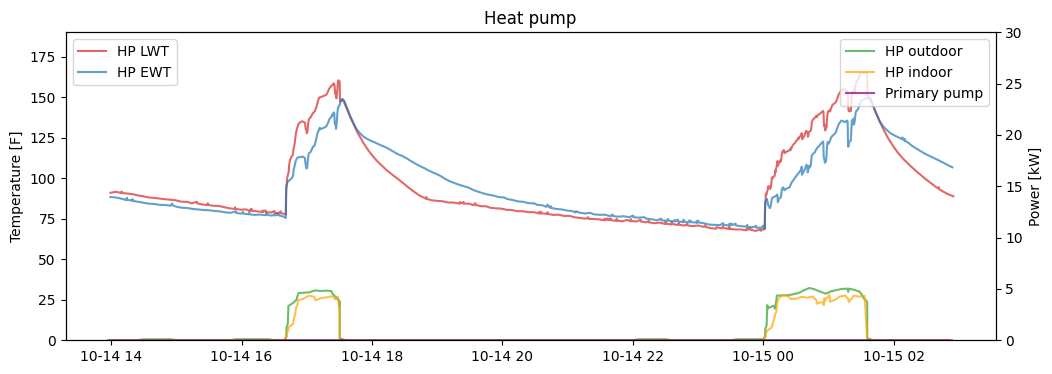

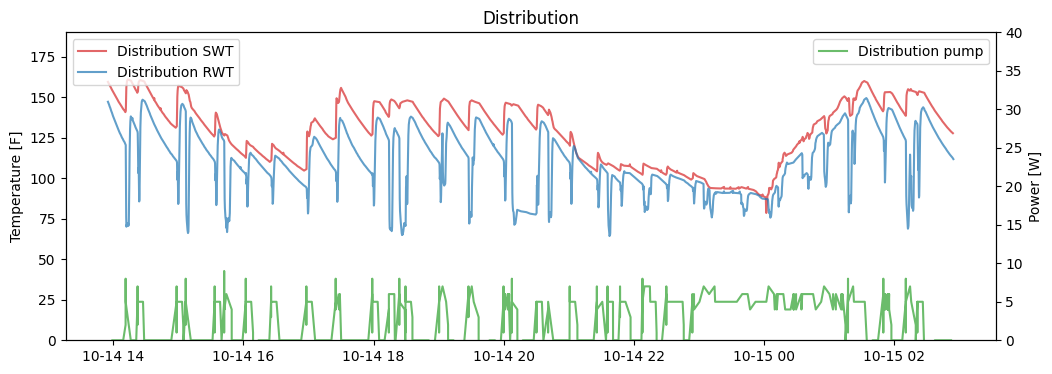

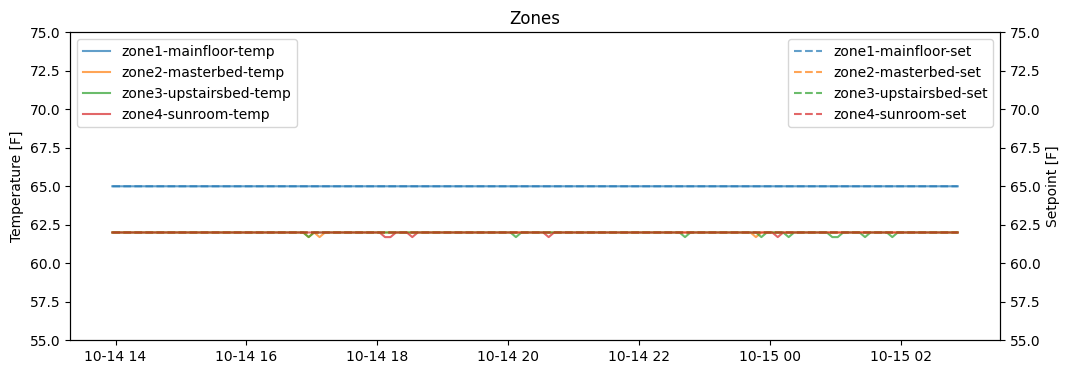

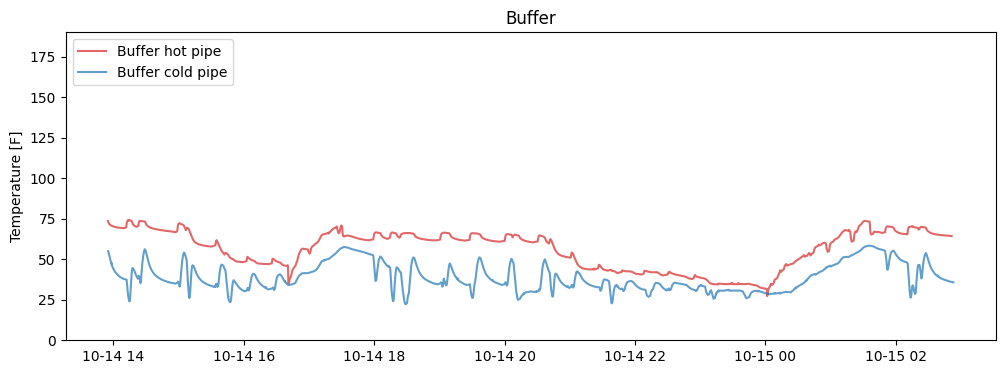

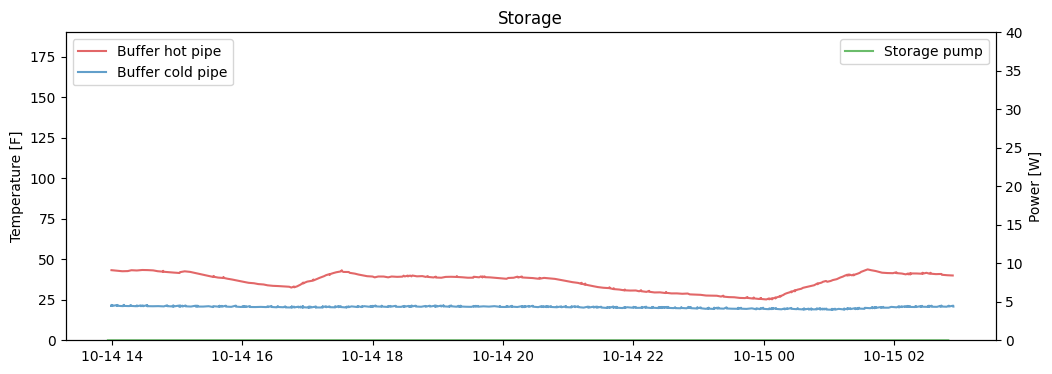

In [143]:
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if channel['ChannelName'] not in channels:
            channels[channel['ChannelName']] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel['ChannelName']]['values'].extend(channel['ValueList'])
            channels[channel['ChannelName']]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
first_time = 1e9**2
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['times'] = list(sorted_times)
    channels[key]['values'] = list(sorted_values)
    if channels[key]['times'][0] < first_time:
        first_time = channels[key]['times'][0]

# --------------------------------------
# First plot: HP loop
# --------------------------------------

first_plot_keys = []
for key in channels.keys():

    if 'hp' in key or 'primary' in key:
        first_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')
        if 'wt' in key:
            channels[key]['values'] = [to_fahrenheit(x) for x in channels[key]['values']]

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(channels['hp-lwt']['times'], channels['hp-lwt']['values'], color='tab:red', alpha=0.7, label='HP LWT')
ax.plot(channels['hp-ewt']['times'], channels['hp-ewt']['values'], color='tab:blue', alpha=0.7, label='HP EWT')
ax.set_ylabel('Temperature [F]')
if max(channels['hp-lwt']['values']) < 190:
    ax.set_ylim([0,190])
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(channels['hp-odu-pwr']['times'], channels['hp-odu-pwr']['values'], color='tab:green', alpha=0.7, label='HP outdoor')
ax2.plot(channels['hp-idu-pwr']['times'], channels['hp-idu-pwr']['values'], color='orange', alpha=0.7, label='HP indoor')
ax2.plot(channels['primary-pump-pwr']['times'], channels['primary-pump-pwr']['values'], color='purple', alpha=0.7, label='Primary pump')
ax2.set_ylabel('Power [kW]')
if max(channels['hp-odu-pwr']['values']) < 30 and max(channels['hp-idu-pwr']['values']) < 30:
    ax2.set_ylim([0,30])
ax2.legend(loc='upper right')
plt.title('Heat pump')
plt.show()

# --------------------------------------
# Second plot: distribution loop
# --------------------------------------

second_plot_keys = []
for key in channels.keys():

    if 'dist' in key: #or 'zone' in key:
        second_plot_keys.append(key)
        if 'pump' not in key and 'zone' not in key:
            channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')
        if 'wt' in key:
            channels[key]['values'] = [to_fahrenheit(x) for x in channels[key]['values']]
        
fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(channels['dist-swt']['times'], channels['dist-swt']['values'], color='tab:red', alpha=0.7, label='Distribution SWT')
ax.plot(channels['dist-rwt']['times'], channels['dist-rwt']['values'], color='tab:blue', alpha=0.7, label='Distribution RWT')
ax.set_ylabel('Temperature [F]')
ax.set_ylim([0,190])
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(channels['dist-pump-pwr']['times'], channels['dist-pump-pwr']['values'], color='tab:green', alpha=0.7, label='Distribution pump')
# for key in channels:
#     if 'zone' in key and 'pwr' in key:
#         ax2.plot(channels[key]['times'], channels[key]['values'], alpha=0.7, label=key)
ax2.set_ylabel('Power [W]')
ax2.set_ylim([0,40])
ax2.legend(loc='upper right')
plt.title('Distribution')
plt.show()

# --------------------------------------
# Third plot: zones
# --------------------------------------

third_plot_keys = []
for key in channels.keys():

    if 'zone' in key:
        third_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')

zones = {}
for key in third_plot_keys:
    if key.split('-')[0] not in zones:
        zones[key.split('-')[0]] = [key]
    else:
        zones[key.split('-')[0]].append(key)

fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax2 = ax.twinx()
colors = {}
for zone in zones:
    for temp in zones[zone]:
        if 'temp' in temp:
            color = ax.plot(channels[temp]['times'], channels[temp]['values'], label=temp, alpha=0.7)[0].get_color()
            colors[temp] = color
        elif 'set' in temp:
            base_temp = temp.replace('-set', '-temp')
            if base_temp in colors:
                ax2.plot(channels[temp]['times'], channels[temp]['values'], label=temp, 
                         linestyle='dashed', color=colors[base_temp], alpha=0.7)
ax.set_ylabel('Temperature [F]')
ax2.set_ylabel('Setpoint [F]')
ax.set_ylim([55, 75])
ax2.set_ylim([55, 75])
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Zones')
plt.show()

# --------------------------------------
# Fourth plot: buffer
# --------------------------------------

fourth_plot_keys = []
for key in channels.keys():
    if 'buffer' in key:
        fourth_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(channels['buffer-hot-pipe']['times'], channels['buffer-hot-pipe']['values'], color='tab:red', alpha=0.7, label='Buffer hot pipe')
ax.plot(channels['buffer-cold-pipe']['times'], channels['buffer-cold-pipe']['values'], color='tab:blue', alpha=0.7, label='Buffer cold pipe')
ax.set_ylabel('Temperature [F]')
ax.set_ylim([0,190])
ax.legend(loc='upper left')
plt.title('Buffer')
plt.show()

# --------------------------------------
# Fifth plot: storage
# --------------------------------------

fifth_plot_keys = []
for key in channels.keys():
    if 'store' in key:
        fifth_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')

fig, ax = plt.subplots(1,1, figsize=(12,4))
ax.plot(channels['store-hot-pipe']['times'], channels['store-hot-pipe']['values'], color='tab:red', alpha=0.7, label='Buffer hot pipe')
ax.plot(channels['store-cold-pipe']['times'], channels['store-cold-pipe']['values'], color='tab:blue', alpha=0.7, label='Buffer cold pipe')
ax.set_ylabel('Temperature [F]')
ax.set_ylim([0,190])
ax.legend(loc='upper left')
ax2 = ax.twinx()
ax2.plot(channels['store-pump-pwr']['times'], channels['store-pump-pwr']['values'], color='tab:green', alpha=0.7, label='Storage pump')
ax2.set_ylabel('Power [W]')
ax2.set_ylim([0,40])
ax2.legend(loc='upper right')
plt.title('Storage')
plt.show()

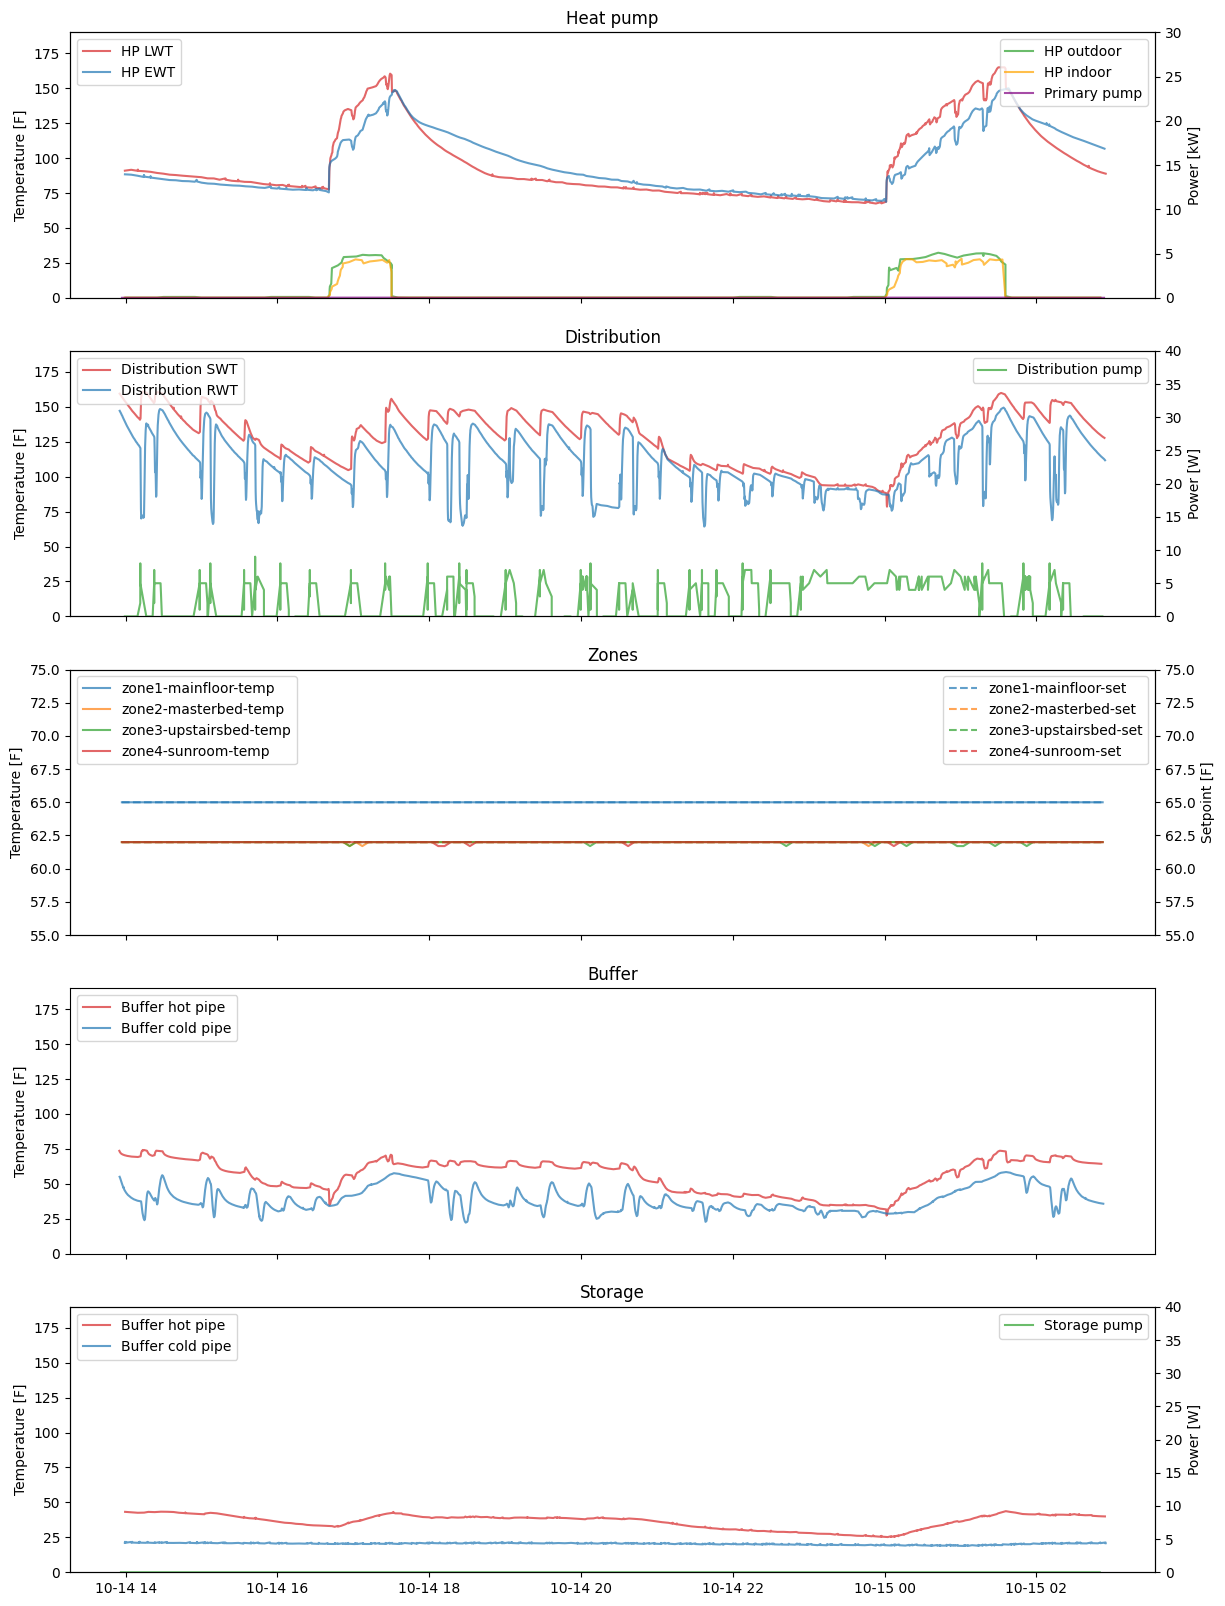

In [154]:
channels = {}
for message in messages:
    for channel in message.payload['ChannelReadingList']:
        if channel['ChannelName'] not in channels:
            channels[channel['ChannelName']] = {
                'values': channel['ValueList'],
                'times': channel['ScadaReadTimeUnixMsList']
            }
        else:
            channels[channel['ChannelName']]['values'].extend(channel['ValueList'])
            channels[channel['ChannelName']]['times'].extend(channel['ScadaReadTimeUnixMsList'])

# Sort values according to time
first_time = 1e9**2
for key in channels.keys():
    sorted_times_values = sorted(zip(channels[key]['times'], channels[key]['values']))
    sorted_times, sorted_values = zip(*sorted_times_values)
    channels[key]['times'] = list(sorted_times)
    channels[key]['values'] = list(sorted_values)
    if channels[key]['times'][0] < first_time:
        first_time = channels[key]['times'][0]

fig, ax = plt.subplots(5,1, figsize=(14,20), sharex=True)

# --------------------------------------
# First plot: HP loop
# --------------------------------------

first_plot_keys = []
for key in channels.keys():

    if 'hp' in key or 'primary' in key:
        first_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')
        if 'wt' in key:
            channels[key]['values'] = [to_fahrenheit(x) for x in channels[key]['values']]

ax[0].plot(channels['hp-lwt']['times'], channels['hp-lwt']['values'], color='tab:red', alpha=0.7, label='HP LWT')
ax[0].plot(channels['hp-ewt']['times'], channels['hp-ewt']['values'], color='tab:blue', alpha=0.7, label='HP EWT')
ax[0].set_ylabel('Temperature [F]')
if max(channels['hp-lwt']['values']) < 190:
    ax[0].set_ylim([0,190])
ax[0].legend(loc='upper left')
ax20 = ax[0].twinx()
ax20.plot(channels['hp-odu-pwr']['times'], channels['hp-odu-pwr']['values'], color='tab:green', alpha=0.7, label='HP outdoor')
ax20.plot(channels['hp-idu-pwr']['times'], channels['hp-idu-pwr']['values'], color='orange', alpha=0.7, label='HP indoor')
ax20.plot(channels['primary-pump-pwr']['times'], channels['primary-pump-pwr']['values'], color='purple', alpha=0.7, label='Primary pump')
ax20.set_ylabel('Power [kW]')
if max(channels['hp-odu-pwr']['values']) < 30 and max(channels['hp-idu-pwr']['values']) < 30:
    ax20.set_ylim([0,30])
ax20.legend(loc='upper right')
ax[0].set_title('Heat pump')

# --------------------------------------
# Second plot: distribution loop
# --------------------------------------

second_plot_keys = []
for key in channels.keys():

    if 'dist' in key: #or 'zone' in key:
        second_plot_keys.append(key)
        if 'pump' not in key and 'zone' not in key:
            channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')
        if 'wt' in key:
            channels[key]['values'] = [to_fahrenheit(x) for x in channels[key]['values']]
        
ax[1].plot(channels['dist-swt']['times'], channels['dist-swt']['values'], color='tab:red', alpha=0.7, label='Distribution SWT')
ax[1].plot(channels['dist-rwt']['times'], channels['dist-rwt']['values'], color='tab:blue', alpha=0.7, label='Distribution RWT')
ax[1].set_ylabel('Temperature [F]')
ax[1].set_ylim([0,190])
ax[1].legend(loc='upper left')
ax21 = ax[1].twinx()
ax21.plot(channels['dist-pump-pwr']['times'], channels['dist-pump-pwr']['values'], color='tab:green', alpha=0.7, label='Distribution pump')
# for key in channels:
#     if 'zone' in key and 'pwr' in key:
#         ax2.plot(channels[key]['times'], channels[key]['values'], alpha=0.7, label=key)
ax21.set_ylabel('Power [W]')
ax21.set_ylim([0,40])
ax21.legend(loc='upper right')
ax[1].set_title('Distribution')

# --------------------------------------
# Third plot: zones
# --------------------------------------

third_plot_keys = []
for key in channels.keys():

    if 'zone' in key:
        third_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')

zones = {}
for key in third_plot_keys:
    if key.split('-')[0] not in zones:
        zones[key.split('-')[0]] = [key]
    else:
        zones[key.split('-')[0]].append(key)

ax22 = ax[2].twinx()
colors = {}
for zone in zones:
    for temp in zones[zone]:
        if 'temp' in temp:
            color = ax[2].plot(channels[temp]['times'], channels[temp]['values'], label=temp, alpha=0.7)[0].get_color()
            colors[temp] = color
        elif 'set' in temp:
            base_temp = temp.replace('-set', '-temp')
            if base_temp in colors:
                ax22.plot(channels[temp]['times'], channels[temp]['values'], label=temp, 
                         linestyle='dashed', color=colors[base_temp], alpha=0.7)
ax[2].set_ylabel('Temperature [F]')
ax22.set_ylabel('Setpoint [F]')
ax[2].set_ylim([55, 75])
ax22.set_ylim([55, 75])
ax[2].legend(loc='upper left')
ax22.legend(loc='upper right')
ax[2].set_title('Zones')

# --------------------------------------
# Fourth plot: buffer
# --------------------------------------

fourth_plot_keys = []
for key in channels.keys():
    if 'buffer' in key:
        fourth_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')

ax[3].plot(channels['buffer-hot-pipe']['times'], channels['buffer-hot-pipe']['values'], color='tab:red', alpha=0.7, label='Buffer hot pipe')
ax[3].plot(channels['buffer-cold-pipe']['times'], channels['buffer-cold-pipe']['values'], color='tab:blue', alpha=0.7, label='Buffer cold pipe')
ax[3].set_ylabel('Temperature [F]')
ax[3].set_ylim([0,190])
ax[3].legend(loc='upper left')
ax[3].set_title('Buffer')

# --------------------------------------
# Fifth plot: storage
# --------------------------------------

fifth_plot_keys = []
for key in channels.keys():
    if 'store' in key:
        fifth_plot_keys.append(key)
        channels[key]['values'] = [x/1000 for x in channels[key]['values']]
        channels[key]['times'] = [x/1000 for x in channels[key]['times']]
        channels[key]['times'] = pd.to_datetime(channels[key]['times'], unit='s')
        channels[key]['times'] = channels[key]['times'].tz_localize('America/New_York')

ax[4].plot(channels['store-hot-pipe']['times'], channels['store-hot-pipe']['values'], color='tab:red', alpha=0.7, label='Buffer hot pipe')
ax[4].plot(channels['store-cold-pipe']['times'], channels['store-cold-pipe']['values'], color='tab:blue', alpha=0.7, label='Buffer cold pipe')
ax[4].set_ylabel('Temperature [F]')
ax[4].set_ylim([0,190])
ax[4].legend(loc='upper left')
ax24 = ax[4].twinx()
ax24.plot(channels['store-pump-pwr']['times'], channels['store-pump-pwr']['values'], color='tab:green', alpha=0.7, label='Storage pump')
ax24.set_ylabel('Power [W]')
ax24.set_ylim([0,40])
ax24.legend(loc='upper right')
ax[4].set_title('Storage')
plt.show()